#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 11
**CH11A Does Smoking Pose a Health Risk?**

using the share-health dataset

version 1.0 2021-05-05

In [2]:
import os
from pathlib import Path
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *
from scipy.stats import logistic
from scipy.stats import norm
from stargazer.stargazer import Stargazer
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import log_loss

warnings.filterwarnings("ignore")


In [74]:
share = pd.read_csv(os.path.join("/workspaces/codespaces-jupyter/data/share_health_p.csv"))
# share = pd.read_csv("https://osf.io/download/snfhe/")

In [75]:
share.columns

Index(['mergeid', 'wave', 'country', 'country_mod', 'int_year', 'int_month',
       'female', 'age', 'eduyears_mod', 'sphus', 'br015_', 'smoking',
       'ever_smoked', 'income_pct_w4', 'bmi', 'mar_stat'],
      dtype='object')

# Part I – create workfile

In [5]:
share["sphus_num"] = share["sphus"].apply(
    lambda x: float(x[1:3]) if x[0] == "-" else float(x[0])
)
share["sphus_num"].unique()

array([ 1.,  5.,  2.,  3.,  4., 12., 15.])

In [6]:
share["healthy"] = 0
share.loc[(share["sphus_num"] == 1) | (share["sphus_num"] == 2), "healthy"] = 1
share.loc[~((share["sphus_num"] > 0) & (share["sphus_num"] <= 5)), "healthy"] = np.nan

In [7]:
share["healthy"].value_counts()

healthy
0.0    274175
1.0     90176
Name: count, dtype: int64

In [8]:
share = share.dropna(how="any")

In [9]:
share["baseline"] = 0
share.loc[share["wave"] == 4, "baseline"] = 1
share["endline"] = 0
share.loc[share["wave"] == 6, "endline"] = 1

In [10]:
share["baseline"].value_counts()

baseline
0    306531
1     57820
Name: count, dtype: int64

In [11]:
share["endline"].value_counts()

endline
0    296305
1     68046
Name: count, dtype: int64

In [12]:
share["temp"] = np.where(
    share["endline"] == 1, np.where(share["healthy"] == 1, 1, 0), np.nan
)

In [13]:
share["temp"].value_counts()


temp
0.0    51213
1.0    16833
Name: count, dtype: int64

In [14]:
share["stayshealthy"] = share.groupby("mergeid")["temp"].transform(np.nanmax)

In [15]:
share["stayshealthy"].value_counts()

stayshealthy
0.0    187467
1.0     59908
Name: count, dtype: int64

In [16]:
share = share.drop("temp", axis=1)

In [17]:
share["stayshealthy"].unique()

array([nan,  0.,  1.])

In [18]:
# keep if endline health outcome non-missing
share = share.loc[lambda x: (x["stayshealthy"] == 1) | (x["stayshealthy"] == 0)]

In [19]:
share["stayshealthy"].unique()

array([0., 1.])

In [20]:
# keep baseline observations (endline outcome already defined for them)
share = share.loc[lambda x: x["baseline"] == 1]

In [21]:
# keep age 50-60 at baseline
share = share.loc[lambda x: (pd.to_numeric(x["age"], errors="coerce") >= 50) & (pd.to_numeric(x["age"], errors="coerce") <= 60)]

In [22]:
# keep healthy individuals at baseline
share = share.loc[lambda x: x["healthy"] == 1]

In [23]:
# keep those with non-missing observations for smoking at baseline
# and re-define smoking to be 0-1
share["smoking_num"] = share["smoking"].apply(lambda x: float(x[1:3]) if x[0] == "-" else float(x[0]))
share["ever_smoked_num"] = share["ever_smoked"].apply(lambda x: float(x[1:3]) if x[0] == "-" else float(x[0]))


share.loc[lambda x: x["smoking_num"] == 5, "smoking_num"] = 0
share = share.loc[lambda x: (x["smoking_num"] == 0) | (x["smoking_num"] == 1)]

share.loc[lambda x: x["ever_smoked_num"] == 5, "ever_smoked_num"] = 0
share = share.loc[lambda x: (x["ever_smoked_num"] == 0) | (x["ever_smoked_num"] == 1)]

In [24]:
share.T

,15,37,59,159,163,219,387,391,481,525,...,363215,363251,363269,363314,363422,363484,363536,363592,363638,363667
mergeid,AT-001492-02,AT-002136-03,AT-002800-01,AT-009262-02,AT-009376-01,AT-011070-01,AT-018393-01,AT-018393-02,AT-020895-01,AT-022738-01,...,SI-962453-02,SI-966058-01,SI-968901-01,SI-972371-01,SI-978791-01,SI-983385-01,SI-988461-01,SI-991974-01,SI-993306-01,SI-994554-01
wave,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
country,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,...,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia
country_mod,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,...,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia
int_year,2011,2011,2011,2011,2011,2011,2011,2011,2011,2011,...,2011,2011,2011,2011,2011,2011,2011,2011,2011,2011
int_month,9. September,8. August,9. September,12. December,9. September,9. September,7. July,7. July,5. May,9. September,...,8. August,8. August,8. August,8. August,8. August,7. July,7. July,8. August,10. October,9. September
female,0. male,1. female,1. female,0. male,0. male,1. female,1. female,0. male,1. female,1. female,...,1. female,0. male,0. male,1. female,1. female,0. male,1. female,1. female,0. male,0. male
age,59.79999923706055,58.20000076293945,60.0,59.29999923706055,53.29999923706055,58.900001525878906,53.29999923706055,52.70000076293945,58.900001525878906,50.400001525878906,...,54.599998474121094,52.79999923706055,51.79999923706055,58.20000076293945,54.20000076293945,55.79999923706055,55.0,53.79999923706055,54.29999923706055,54.599998474121094
eduyears_mod,13.0,14.0,23.0,12.0,3.0,14.0,11.0,12.0,3.0,-3. implausible value/suspected wrong,...,12.0,14.0,16.0,8.0,12.0,16.0,17.0,11.0,4.0,13.0
sphus,2. Very good,1. Excellent,2. Very good,2. Very good,2. Very good,2. Very good,1. Excellent,2. Very good,1. Excellent,2. Very good,...,2. Very good,2. Very good,1. Excellent,2. Very good,1. Excellent,1. Excellent,2. Very good,2. Very good,1. Excellent,2. Very good


In [103]:
share["br015_num"] = share["br015_"].apply(lambda x: float(x[1:3]) if x[0] == "-" else float(x[0]))


In [26]:
share["exerc"] = np.where(
    share["br015_num"] == 1,
    1,
    np.where((share["br015_num"] > 0) & (share["br015_num"] != 1), 0, np.nan),
)
share["exerc"].value_counts()

exerc
1.0    1698
0.0    1567
Name: count, dtype: int64

In [27]:
share.T

,15,37,59,159,163,219,387,391,481,525,...,363215,363251,363269,363314,363422,363484,363536,363592,363638,363667
mergeid,AT-001492-02,AT-002136-03,AT-002800-01,AT-009262-02,AT-009376-01,AT-011070-01,AT-018393-01,AT-018393-02,AT-020895-01,AT-022738-01,...,SI-962453-02,SI-966058-01,SI-968901-01,SI-972371-01,SI-978791-01,SI-983385-01,SI-988461-01,SI-991974-01,SI-993306-01,SI-994554-01
wave,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
country,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,...,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia
country_mod,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,...,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia
int_year,2011,2011,2011,2011,2011,2011,2011,2011,2011,2011,...,2011,2011,2011,2011,2011,2011,2011,2011,2011,2011
int_month,9. September,8. August,9. September,12. December,9. September,9. September,7. July,7. July,5. May,9. September,...,8. August,8. August,8. August,8. August,8. August,7. July,7. July,8. August,10. October,9. September
female,0. male,1. female,1. female,0. male,0. male,1. female,1. female,0. male,1. female,1. female,...,1. female,0. male,0. male,1. female,1. female,0. male,1. female,1. female,0. male,0. male
age,59.79999923706055,58.20000076293945,60.0,59.29999923706055,53.29999923706055,58.900001525878906,53.29999923706055,52.70000076293945,58.900001525878906,50.400001525878906,...,54.599998474121094,52.79999923706055,51.79999923706055,58.20000076293945,54.20000076293945,55.79999923706055,55.0,53.79999923706055,54.29999923706055,54.599998474121094
eduyears_mod,13.0,14.0,23.0,12.0,3.0,14.0,11.0,12.0,3.0,-3. implausible value/suspected wrong,...,12.0,14.0,16.0,8.0,12.0,16.0,17.0,11.0,4.0,13.0
sphus,2. Very good,1. Excellent,2. Very good,2. Very good,2. Very good,2. Very good,1. Excellent,2. Very good,1. Excellent,2. Very good,...,2. Very good,2. Very good,1. Excellent,2. Very good,1. Excellent,1. Excellent,2. Very good,2. Very good,1. Excellent,2. Very good


In [28]:
share["bmi"].unique()

array(['23.198314666748047', '24.80158805847168', '22.03856658935547',
       ..., '26.173831939697266', '29.270994186401367',
       '25.420015335083008'], shape=(1186,), dtype=object)

In [29]:
share["bmi"] = share["bmi"].apply(lambda x: 0 if str(x)[0] == "-" else float(x))
share["bmi"] = np.where(share["bmi"] < 0, np.nan, share["bmi"])
share["bmi"].describe().round(2)


count    3265.00
mean       24.95
std         5.44
min         0.00
25%        22.60
50%        24.97
75%        27.76
max        45.63
Name: bmi, dtype: float64

In [30]:
share = share.rename(columns={"income_pct_w4": "income10"})

In [31]:
share["married"] = np.where((share["mar_stat"] == 1) | (share["mar_stat"] == 2), 1, 0)

In [32]:
share.T

,15,37,59,159,163,219,387,391,481,525,...,363215,363251,363269,363314,363422,363484,363536,363592,363638,363667
mergeid,AT-001492-02,AT-002136-03,AT-002800-01,AT-009262-02,AT-009376-01,AT-011070-01,AT-018393-01,AT-018393-02,AT-020895-01,AT-022738-01,...,SI-962453-02,SI-966058-01,SI-968901-01,SI-972371-01,SI-978791-01,SI-983385-01,SI-988461-01,SI-991974-01,SI-993306-01,SI-994554-01
wave,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
country,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,11. Austria,...,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia,34. Slovenia
country_mod,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,40. Austria,...,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia,705. Slovenia
int_year,2011,2011,2011,2011,2011,2011,2011,2011,2011,2011,...,2011,2011,2011,2011,2011,2011,2011,2011,2011,2011
int_month,9. September,8. August,9. September,12. December,9. September,9. September,7. July,7. July,5. May,9. September,...,8. August,8. August,8. August,8. August,8. August,7. July,7. July,8. August,10. October,9. September
female,0. male,1. female,1. female,0. male,0. male,1. female,1. female,0. male,1. female,1. female,...,1. female,0. male,0. male,1. female,1. female,0. male,1. female,1. female,0. male,0. male
age,59.79999923706055,58.20000076293945,60.0,59.29999923706055,53.29999923706055,58.900001525878906,53.29999923706055,52.70000076293945,58.900001525878906,50.400001525878906,...,54.599998474121094,52.79999923706055,51.79999923706055,58.20000076293945,54.20000076293945,55.79999923706055,55.0,53.79999923706055,54.29999923706055,54.599998474121094
eduyears_mod,13.0,14.0,23.0,12.0,3.0,14.0,11.0,12.0,3.0,-3. implausible value/suspected wrong,...,12.0,14.0,16.0,8.0,12.0,16.0,17.0,11.0,4.0,13.0
sphus,2. Very good,1. Excellent,2. Very good,2. Very good,2. Very good,2. Very good,1. Excellent,2. Very good,1. Excellent,2. Very good,...,2. Very good,2. Very good,1. Excellent,2. Very good,1. Excellent,1. Excellent,2. Very good,2. Very good,1. Excellent,2. Very good


In [33]:
share = share[~share["eduyears_mod"].astype(str).str.startswith("-")]

In [34]:
share["eduyears_mod"] = share["eduyears_mod"].astype(float)
share["eduyears"] = np.where(share["eduyears_mod"] < 0, np.nan, share["eduyears_mod"])
share["eduyears"].describe().round(2)

count    3175.00
mean       12.32
std         4.57
min         0.00
25%        10.00
50%        12.00
75%        16.00
max        25.00
Name: eduyears, dtype: float64

In [35]:
share = share.drop("eduyears_mod", axis=1)


In [36]:
share = share.loc[
    lambda x: (x["bmi"].notnull()) & (x["eduyears"].notnull()) & (x["exerc"].notnull())
]


In [37]:
share["female"] = share["female"].apply(lambda x: float(str(x)[0]))
share["age"] = share["age"].astype(float)
share["income10"] = share["income10"].astype(float)
share[["female", "age","income10"]]

,female,age,income10
15,0.0,59.799999,8.0
37,1.0,58.200001,9.0
59,1.0,60.000000,2.0
159,0.0,59.299999,6.0
163,0.0,53.299999,8.0
...,...,...,...
363484,0.0,55.799999,9.0
363536,1.0,55.000000,10.0
363592,1.0,53.799999,7.0
363638,0.0,54.299999,10.0


In [38]:
share.filter(
    [
        "stayshealthy",
        "smoking_num",
        "ever_smoked_num",
        "female",
        "age",
        "income10",
        "eduyears",
        "bmi",
        "exerc",
    ]
).describe().round(2)


,stayshealthy,smoking_num,ever_smoked_num,female,age,income10,eduyears,bmi,exerc
count,3175.00,3175.00,3175.00,3175.00,3175.00,3175.00,3175.00,3175.00,3175.00
mean,0.60,0.22,0.49,0.56,55.19,6.77,12.32,24.94,0.52
std,0.49,0.42,0.50,0.50,2.79,2.75,4.57,5.46,0.50
min,0.00,0.00,0.00,0.00,50.00,1.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,52.80,5.00,10.00,22.60,0.00
50%,1.00,0.00,0.00,1.00,55.30,7.00,12.00,24.97,1.00
75%,1.00,0.00,1.00,1.00,57.50,9.00,16.00,27.76,1.00
max,1.00,1.00,1.00,1.00,60.00,10.00,25.00,45.63,1.00


In [39]:
pd.crosstab(share["country"], share["stayshealthy"])

stayshealthy,0.0,1.0
country,,
11. Austria,125,256
12. Germany,21,25
13. Sweden,25,55
15. Spain,89,101
16. Italy,120,86
17. France,136,170
18. Denmark,73,325
20. Switzerland,134,316
23. Belgium,176,268


In [40]:
share_france = share[share['country'] == '17. France'] 
share_poland = share[share['country'] == '29. Poland']

In [41]:
share_france

,mergeid,wave,country,country_mod,int_year,int_month,female,age,sphus,br015_,...,healthy,baseline,endline,stayshealthy,smoking_num,ever_smoked_num,br015_num,exerc,married,eduyears
189720,F1-010305-02,4,17. France,250. France,2011,5. May,0.0,57.599998,1. Excellent,"4. Hardly ever, or never",...,1.0,1,0,0.0,1.0,1.0,4.0,0.0,0,11.0
189827,F1-017400-02,4,17. France,250. France,2011,8. August,1.0,54.900002,2. Very good,1. More than once a week,...,1.0,1,0,1.0,1.0,1.0,1.0,1.0,0,14.0
189924,F1-030440-01,4,17. France,250. France,2011,6. June,1.0,56.299999,1. Excellent,"4. Hardly ever, or never",...,1.0,1,0,0.0,0.0,0.0,4.0,0.0,0,16.0
189940,F1-032181-02,4,17. France,250. France,2011,7. July,0.0,51.099998,1. Excellent,1. More than once a week,...,1.0,1,0,1.0,0.0,1.0,1.0,1.0,0,12.0
189980,F1-038141-02,4,17. France,250. France,2011,3. March,1.0,50.299999,2. Very good,"4. Hardly ever, or never",...,1.0,1,0,0.0,0.0,0.0,4.0,0.0,0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217176,FR-957387-01,4,17. France,250. France,2011,5. May,0.0,52.900002,2. Very good,2. Once a week,...,1.0,1,0,1.0,1.0,1.0,2.0,0.0,0,12.0
217454,FR-975952-01,4,17. France,250. France,2011,5. May,0.0,56.400002,2. Very good,"4. Hardly ever, or never",...,1.0,1,0,0.0,1.0,0.0,4.0,0.0,0,10.0
217634,FR-986396-01,4,17. France,250. France,2011,4. April,1.0,52.299999,1. Excellent,3. One to three times a month,...,1.0,1,0,1.0,0.0,1.0,3.0,0.0,0,14.0
217809,FR-995817-01,4,17. France,250. France,2011,5. May,1.0,51.799999,2. Very good,"4. Hardly ever, or never",...,1.0,1,0,0.0,1.0,1.0,4.0,0.0,0,14.0


In [42]:
share_poland

,mergeid,wave,country,country_mod,int_year,int_month,female,age,sphus,br015_,...,healthy,baseline,endline,stayshealthy,smoking_num,ever_smoked_num,br015_num,exerc,married,eduyears
309071,PL-009467-01,4,29. Poland,616. Poland,2012,3. March,1.0,56.000000,1. Excellent,"4. Hardly ever, or never",...,1.0,1,0,1.0,0.0,1.0,4.0,0.0,0,13.0
309206,PL-020417-02,4,29. Poland,616. Poland,2012,1. January,1.0,53.799999,2. Very good,1. More than once a week,...,1.0,1,0,1.0,1.0,1.0,1.0,1.0,0,11.0
309631,PL-053763-01,4,29. Poland,616. Poland,2012,3. March,1.0,57.400002,2. Very good,"4. Hardly ever, or never",...,1.0,1,0,1.0,0.0,0.0,4.0,0.0,0,11.0
310285,PL-108802-01,4,29. Poland,616. Poland,2012,1. January,1.0,56.799999,2. Very good,1. More than once a week,...,1.0,1,0,0.0,1.0,1.0,1.0,1.0,0,10.0
310293,PL-109013-01,4,29. Poland,616. Poland,2012,1. January,0.0,57.299999,2. Very good,1. More than once a week,...,1.0,1,0,1.0,0.0,1.0,1.0,1.0,0,14.0
311031,PL-156151-01,4,29. Poland,616. Poland,2012,1. January,0.0,56.299999,2. Very good,1. More than once a week,...,1.0,1,0,0.0,0.0,1.0,1.0,1.0,0,11.0
311153,PL-163873-01,4,29. Poland,616. Poland,2012,2. February,0.0,60.000000,2. Very good,1. More than once a week,...,1.0,1,0,1.0,1.0,1.0,1.0,1.0,0,8.0
311232,PL-169490-01,4,29. Poland,616. Poland,2012,2. February,1.0,56.799999,2. Very good,2. Once a week,...,1.0,1,0,1.0,0.0,1.0,2.0,0.0,0,8.0
311590,PL-195759-01,4,29. Poland,616. Poland,2012,2. February,0.0,56.299999,2. Very good,3. One to three times a month,...,1.0,1,0,1.0,0.0,1.0,3.0,0.0,0,12.0
312230,PL-247202-01,4,29. Poland,616. Poland,2012,2. February,0.0,58.299999,2. Very good,1. More than once a week,...,1.0,1,0,0.0,0.0,1.0,1.0,1.0,0,14.0


#  2. PART - SIMPLE LPM MODELS

In [43]:
lpm1fr = smf.ols("stayshealthy ~ smoking_num", data=share_france).fit(cov_type="HC1")
lpm1pol = smf.ols("stayshealthy ~ smoking_num", data=share_poland).fit(cov_type="HC1")

In [44]:
lpm2fr = smf.ols("stayshealthy ~ smoking_num + ever_smoked_num", data=share_france).fit(covtype="HC1")
lpm2pol = smf.ols("stayshealthy ~ smoking_num + ever_smoked_num", data=share_poland).fit(covtype="HC1")

### Table 11.1 Probability of staying healthy

In [45]:
results = pd.DataFrame({
    "Model France 1 Coef": lpm1fr.params,
    "Model France 1 P-value": lpm1fr.pvalues,
    "Model Poland 1 Coef": lpm1pol.params,
    "Model Poland 1 P-value": lpm1pol.pvalues,
    "Model France 2 Coef": lpm2fr.params,
    "Model France 2 P-value": lpm2fr.pvalues,
    "Model Poland 2 Coef": lpm2pol.params,
    "Model Poland 2 P-value": lpm2pol.pvalues,
})
print(results)


                 Model France 1 Coef  Model France 1 P-value  \
Intercept                   0.569767            8.438868e-76   
ever_smoked_num                  NaN                     NaN   
smoking_num                -0.090601            2.494971e-01   

                 Model Poland 1 Coef  Model Poland 1 P-value  \
Intercept                   0.350000                0.001454   
ever_smoked_num                  NaN                     NaN   
smoking_num                -0.064286                0.698656   

                 Model France 2 Coef  Model France 2 P-value  \
Intercept                   0.589401            5.724452e-38   
ever_smoked_num            -0.049660            4.268768e-01   
smoking_num                -0.062643            4.657325e-01   

                 Model Poland 2 Coef  Model Poland 2 P-value  
Intercept                   0.333333                0.049279  
ever_smoked_num             0.030303                0.891158  
smoking_num                -0.077922    

In [46]:
lpm1fr.summary(),


(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:           stayshealthy   R-squared:                       0.004
 Model:                            OLS   Adj. R-squared:                  0.001
 Method:                 Least Squares   F-statistic:                     1.326
 Date:                Wed, 16 Jul 2025   Prob (F-statistic):              0.250
 Time:                        02:20:31   Log-Likelihood:                -219.52
 No. Observations:                 306   AIC:                             443.0
 Df Residuals:                     304   BIC:                             450.5
 Df Model:                           1                                         
 Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
 --------------------------------------------------------------------

In [47]:
lpm1pol.summary(),


(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:           stayshealthy   R-squared:                       0.005
 Model:                            OLS   Adj. R-squared:                 -0.027
 Method:                 Least Squares   F-statistic:                    0.1499
 Date:                Wed, 16 Jul 2025   Prob (F-statistic):              0.701
 Time:                        02:20:31   Log-Likelihood:                -22.337
 No. Observations:                  34   AIC:                             48.67
 Df Residuals:                      32   BIC:                             51.73
 Df Model:                           1                                         
 Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
 --------------------------------------------------------------------

In [48]:
lpm2fr.summary(),


(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:           stayshealthy   R-squared:                       0.006
 Model:                            OLS   Adj. R-squared:                 -0.000
 Method:                 Least Squares   F-statistic:                    0.9870
 Date:                Wed, 16 Jul 2025   Prob (F-statistic):              0.374
 Time:                        02:20:31   Log-Likelihood:                -219.20
 No. Observations:                 306   AIC:                             444.4
 Df Residuals:                     303   BIC:                             455.6
 Df Model:                           2                                         
 Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
 ----------------------------------------------------------------

In [50]:
stargazer = Stargazer([lpm1fr, lpm2fr, lpm1pol, lpm2pol])
stargazer.covariate_order(["smoking_num", "ever_smoked_num", "Intercept"])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer


In [51]:
ci_95 = lpm1fr.conf_int()
print("95% Confidence Intervals:")
print(ci_95)

95% Confidence Intervals:
                    0         1
Intercept    0.509155  0.630380
smoking_num -0.244802  0.063601


In [52]:
share_france["pred1"] = lpm1fr.predict()
pd.crosstab(index=share_france["pred1"], columns=share_france["smoking"])

smoking,1. Yes,5. No
pred1,,
0.479167,48,0
0.569767,0,258


In [53]:
share_poland["pred1"] = lpm1pol.predict()
pd.crosstab(index=share_poland["pred1"], columns=share_poland["smoking"])

smoking,1. Yes,5. No
pred1,,
0.285714,14,0
0.350000,0,20


In [54]:
pd.crosstab(index=share_france["stayshealthy"], columns=share["smoking"])


smoking,1. Yes,5. No
stayshealthy,,
0.0,25,111
1.0,23,147


In [55]:
pd.crosstab(index=share_poland["stayshealthy"], columns=share["smoking"])


smoking,1. Yes,5. No
stayshealthy,,
0.0,10,13
1.0,4,7


In [56]:
share_france["weight"] = share_france.groupby(["smoking", "stayshealthy"])["smoking"].transform(len)
share_france["weight_2"] = share_france["weight"] / 1000


In [57]:
share_poland["weight"] = share_poland.groupby(["smoking", "stayshealthy"])["smoking"].transform(len)
share_poland["weight_2"] = share_poland["weight"] / 1000


### Figure 11.1 Staying healthy and smoking – scatterplot and regression line

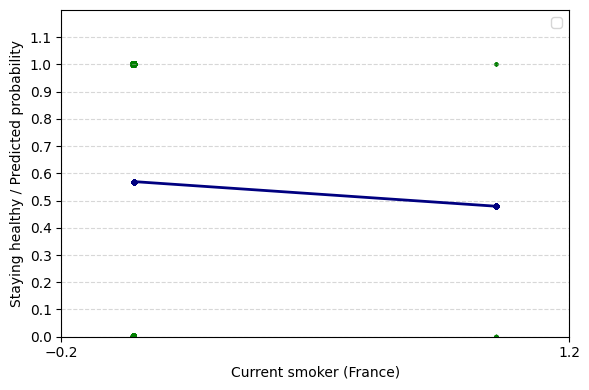

In [61]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 4))

# Scatter plot for predicted probability
ax.scatter(share_france["smoking_num"], share_france["pred1"], s=10, color="navy", label="Predicted probability")

# Line plot for predicted probability
smoking_vals = np.sort(share_france["smoking_num"].unique())
pred_means = [share_france.loc[share_france["smoking_num"] == val, "pred1"].mean() for val in smoking_vals]
ax.plot(smoking_vals, pred_means, color="navy", linewidth=2)

# Scatter plot for actual stayshealthy, sized by weight_2
ax.scatter(
    share_france["smoking_num"],
    share_france["stayshealthy"],
    s=share_france["weight_2"] * 100,  # scale marker size
    color="green",
    alpha=0.8,
    label="Actual stayshealthy"
)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1.2)
ax.set_xlabel("Current smoker (France)")
ax.set_ylabel("Staying healthy / Predicted probability")
ax.set_xticks([-0.2, 1.2])
ax.set_yticks(np.arange(0, 1.2, 0.1))
ax.legend("")
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

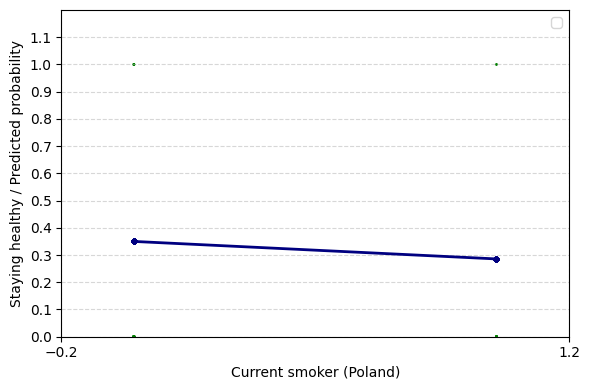

In [63]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 4))

# Scatter plot for predicted probability
ax.scatter(share_poland["smoking_num"], share_poland["pred1"], s=10, color="navy", label="Predicted probability")

# Line plot for predicted probability
smoking_vals = np.sort(share_poland["smoking_num"].unique())
pred_means = [share_poland.loc[share_poland["smoking_num"] == val, "pred1"].mean() for val in smoking_vals]
ax.plot(smoking_vals, pred_means, color="navy", linewidth=2)

# Scatter plot for actual stayshealthy, sized by weight_2
ax.scatter(
    share_poland["smoking_num"],
    share_poland["stayshealthy"],
    s=share_poland["weight_2"] * 100,  # scale marker size
    color="green",
    alpha=0.8,
    label="Actual stayshealthy"
)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1.2)
ax.set_xlabel("Current smoker (Poland)")
ax.set_ylabel("Staying healthy / Predicted probability")
ax.set_xticks([-0.2, 1.2])
ax.set_yticks(np.arange(0, 1.2, 0.1))
ax.legend("")
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [64]:
share_france["weight"] = (
    share_france.groupby(["eduyears", "stayshealthy"])["smoking"].transform(len) / 100
)

share_poland["weight"] = (
    share_poland.groupby(["eduyears", "stayshealthy"])["smoking"].transform(len) / 100
)


### Figure 11.2 Education, income, and the probability of staying healthy – non-parametric regressions

(a) Staying healthy and years of education

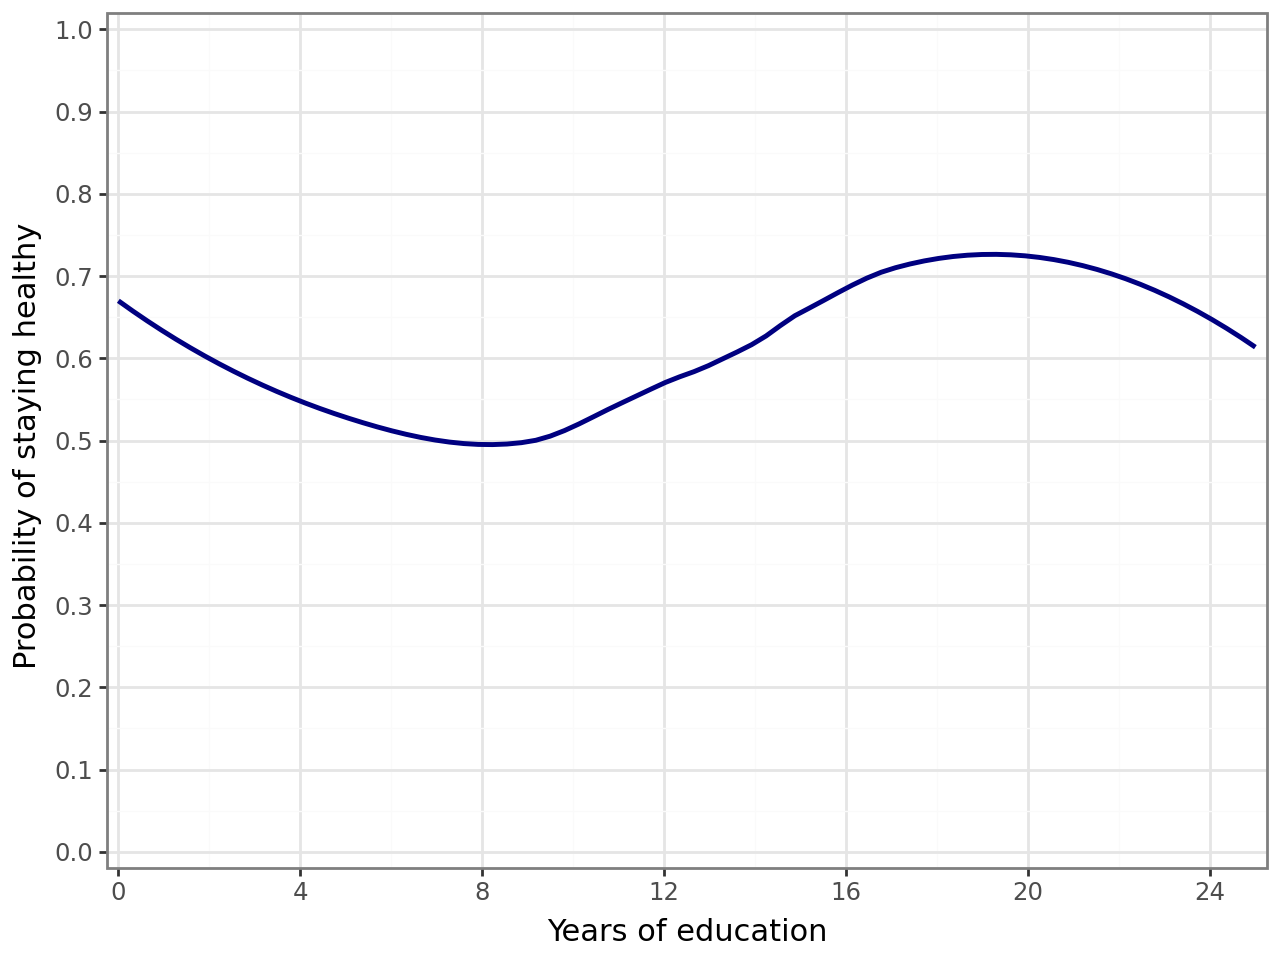

In [ ]:
g2 = (
    ggplot(data=share)
    + geom_smooth(
        aes(x="eduyears", y="stayshealthy"), method="loess", se=False, color="navy"
    )
    + labs(x="Years of education", y="Probability of staying healthy ")
    # + coord_cartesian(xlim = [0, 1], ylim=[0,1])
    + scale_x_continuous(expand=[0.01, 0.01], limits=[0, 25], breaks=np.arange(0, 25, 4))
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=np.arange(0, 1.1, 0.1))
    + theme_bw()
)
g2


(b) Staying healthy and income group

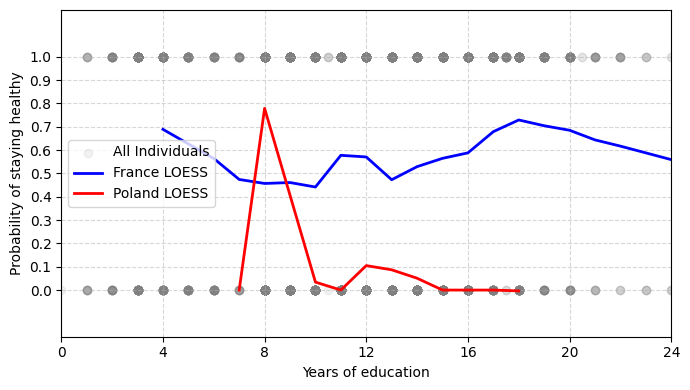

In [72]:
#Probablity of staying healthy by years of education with LOESS fits for France and Poland

from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 4))

# Scatter plot for all data
ax.scatter(share["eduyears"], share["stayshealthy"], alpha=0.1, color="gray", label="All Individuals")

# LOESS for France
loess_fr = lowess(share_france["stayshealthy"], share_france["eduyears"], frac=0.3)
ax.plot(loess_fr[:, 0], loess_fr[:, 1], color="blue", linewidth=2, label="France LOESS")

# LOESS for Poland
loess_pl = lowess(share_poland["stayshealthy"], share_poland["eduyears"], frac=0.3)
ax.plot(loess_pl[:, 0], loess_pl[:, 1], color="red", linewidth=2, label="Poland LOESS")

ax.set_xlabel("Years of education")
ax.set_ylabel("Probability of staying healthy")
ax.set_xlim(0, 24)
ax.set_ylim(-0.2, 1.2)
ax.set_xticks(range(0, 25, 4))
ax.set_yticks([round(x, 2) for x in np.arange(0, 1.1, 0.1)])
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()


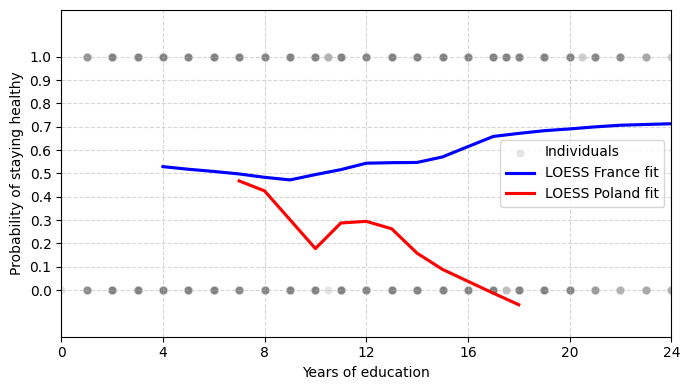

In [ ]:
# Probablity of staying healthy by years of education with LOESS fits for France and Poland

import seaborn as sns

plt.figure(figsize=(7, 4))
sns.scatterplot(x="eduyears", y="stayshealthy", data=share, alpha=0.2, color="gray", label="Individuals") # all data
sns.regplot(x="eduyears", y="stayshealthy", data=share_france, lowess=True, scatter=False, color="blue", label="LOESS France fit")
sns.regplot(x="eduyears", y="stayshealthy", data=share_poland, lowess=True, scatter=False, color="red", label="LOESS Poland fit")

plt.xlabel("Years of education")
plt.ylabel("Probability of staying healthy")
plt.xlim(0, 24)
plt.ylim(-0.2, 1.2)
plt.xticks(range(0, 25, 4))
plt.yticks([round(x, 2) for x in np.arange(0, 1.1, 0.1)])
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


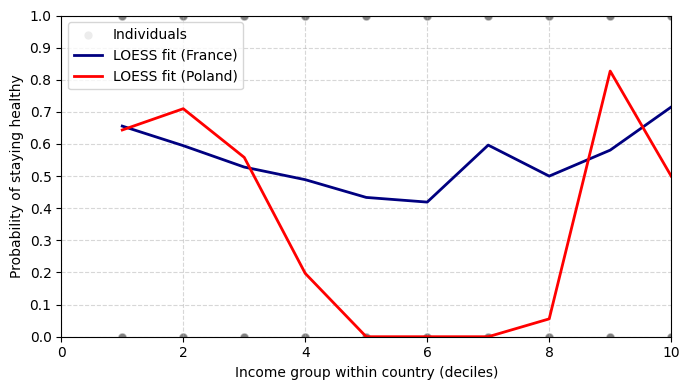

In [71]:
#Probablity of staying healthy by income group within country (deciles) with LOESS fits for France and Poland

import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 4))

# Scatter plot for all data
sns.scatterplot(x="income10", y="stayshealthy", data=share, alpha=0.15, color="gray", ax=ax, label="Individuals")

# LOESS
loess_france = lowess(share_france["stayshealthy"], share_france["income10"], frac=0.3)
loess_poland = lowess(share_poland["stayshealthy"], share_poland["income10"], frac=0.3)
ax.plot(loess_france[:, 0], loess_france[:, 1], color="navy", linewidth=2, label="LOESS fit (France)")
ax.plot(loess_poland[:, 0], loess_poland[:, 1], color="red", linewidth=2, label="LOESS fit (Poland)")

ax.set_xlabel("Income group within country (deciles)")
ax.set_ylabel("Probability of staying healthy")
ax.set_xlim(1, 10)
ax.set_ylim(0, 1)
ax.set_xticks(range(0, 11, 2))
ax.set_yticks([round(x, 2) for x in np.arange(0, 1.1, 0.1)])
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()


Not in the book

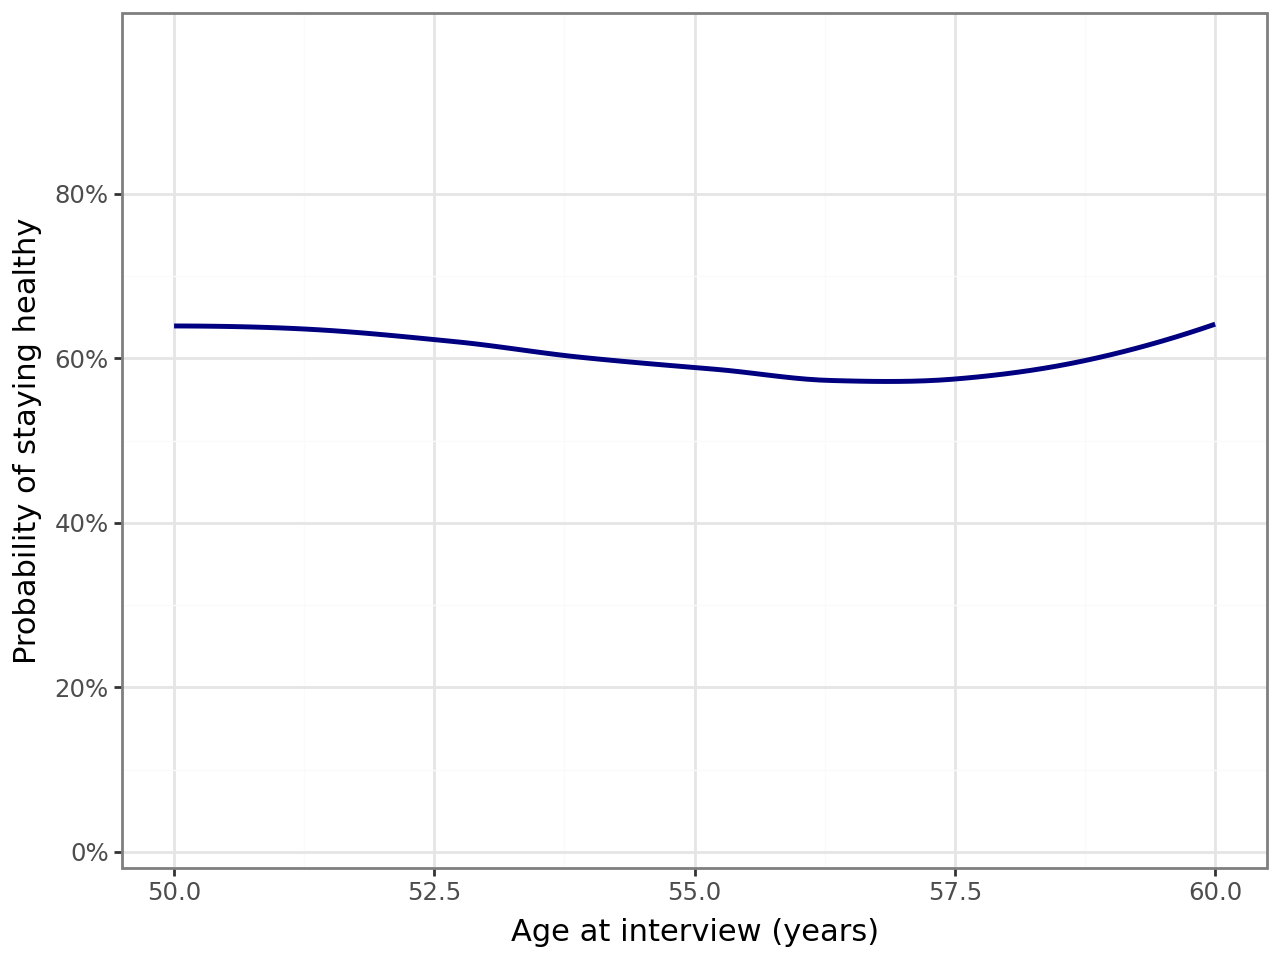

In [ ]:
g2c = (
    ggplot(data=share)
    + geom_smooth(
        aes(x="age", y="stayshealthy"), method="loess", se=False, color="navy"
    )
    + scale_y_continuous(
        expand=[0.01, 0.01],
        limits=[0, 1],
        breaks=np.arange(0, 1, 0.2),
        labels=percent_format(),
    )
    + labs(x="Age at interview (years)", y="Probability of staying healthy")
    + theme_bw()
)
g2c


Not in the book

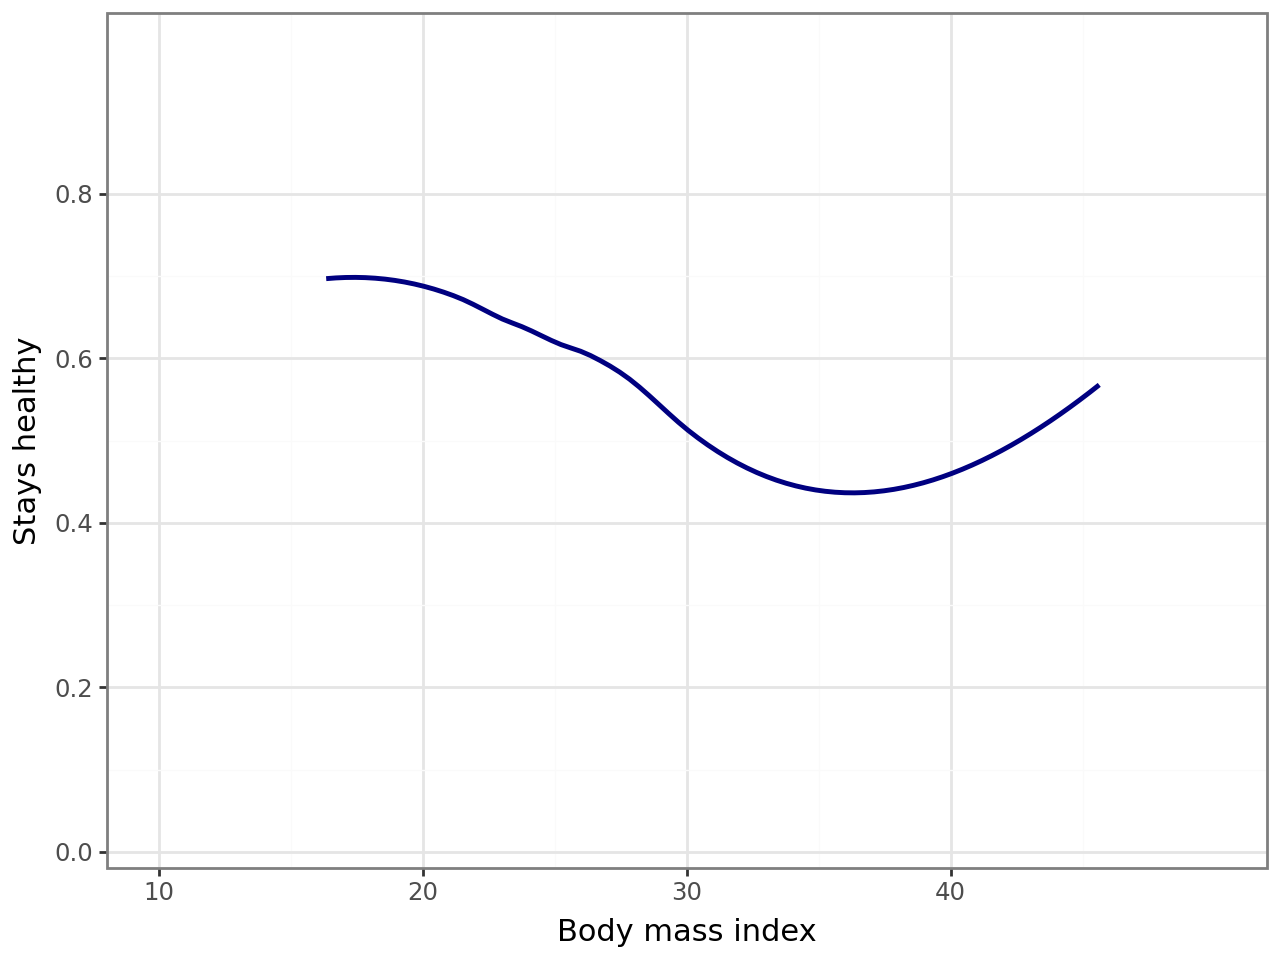

In [ ]:
g2d = (
    ggplot(data=share)
    + geom_smooth(
        aes(x="bmi", y="stayshealthy"), method="loess", se=False, color="navy"
    )
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=np.arange(0, 1, 0.2))
    + scale_x_continuous(limits=[10, 50], breaks=np.arange(10, 50, 10))
    + labs(x="Body mass index", y="Stays healthy")
    + theme_bw()
)
g2d


# 3. PART - PROBABILITY MODELS (LPM, LOGIT, PROBIT) & PREDICTION

In [132]:
share.columns

Index(['mergeid', 'wave', 'country', 'country_mod', 'int_year', 'int_month',
       'female', 'age', 'eduyears_mod', 'sphus', 'br015_', 'smoking',
       'ever_smoked', 'income_pct_w4', 'bmi', 'mar_stat', 'married_new',
       'br015_num', 'train', 'married'],
      dtype='object')

In [129]:
share["married"] = np.where((share["mar_stat"] == "1. Married and living together with spouse") | 
                            (share["mar_stat"] == "2. Married and living apart from spouse"), 1, 0)
share["married"] = np.where((share["mar_stat"] == 1) | (share["mar_stat"] == 2), 1, 0) # only married and living together with spouse
share["married_new"] = share["mar_stat"].apply(
    lambda x: 1 if x == "1. Married and living together with spouse" else (0 if x == "4. Never married" else np.nan) # only married and living together with spouse or never married
) 

In [128]:
share["br015_num"] = share["br015_"].apply(lambda x: float(x[1:3]) if x[0] == "-" else float(x[0]))
share["train"] = np.where((share["br015_num"] == 1) | (share["br015_num"] == 2), 1, 0)

In [143]:
share["income_pct_w4_num"] = share["income_pct_w4"].apply(lambda x: float(x[1:3]) if x[0] == "-" else float(x[0]))
share=share[share["income_pct_w4"] != '-13. not asked in this wave']

share["high_income"] = np.where((share["income_pct_w4_num"] >= 10) | (share["income_pct_w4_num"] >=6), 1, 0) # people with high income 
share["low_income"] = np.where((share["income_pct_w4_num"] < 6), 1, 0) # people with low income

In [144]:
share["income_pct_w4_num"].unique()

array([1., 2., 8., 4., 9., 5., 6., 3., 7.])

In [ ]:
lpm_exerc = smf.ols(
    "train ~ married + ",
    share,
).fit(covtype="HC1")


### Table 11.2 Smoking and the probability of staying healthy – rich LPM

In [ ]:
stargazer = Stargazer([lpm3])
stargazer.covariate_order(
    [
        "smoking_num",
        "ever_smoked_num",
        "female",
        "age",
        "lspline_0",
        "lspline_1",
        "lspline_2",
        "income10",
        "lspline_4",
        "lspline_5",
        "exerc",
    ]
)
stargazer.rename_covariates({"Intercept": "Constant", "lspline_0": "Years of Education (if < 8)", "lspline_1": "Years of Education (if 8-12)", 
                             "lspline_2": "Years of Education (if > 12)", "lspline_4": "BMI (if < 35)", "lspline_5":  "BMI (if >= 35)"})
stargazer.add_line("Country indicators", ["Yes"])
stargazer


In [ ]:
lpm3.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           stayshealthy   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     14.45
Date:                Tue, 15 Jul 2025   Prob (F-statistic):           1.33e-55
Time:                        18:11:31   Log-Likelihood:                -2069.9
No. Observations:                3175   AIC:                             4190.
Df Residuals:                    3150   BIC:                             4341.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.8059      0.183      4.397      0.000       0.446       1.165
country[T.12. Germany]           -0.1962      0.074     -2.655      0.008      -0.341      -0.051
country[T.13. Sweden]            -0.0274      0.059     -0.466      0.641      -0.142       0.088
country[T.15. Spain]             -0.1469      0.042     -3.524      0.000      -0.229      -0.065
country[T.16. Italy]             -0.2385      0.041     -5.862      0.000      -0.318      -0.159
country[T.17. France]            -0.1546      0.037     -4.224      0.000      -0.226      -0.083
country[T.18. Denmark]            0.0770      0.035      2.201      0.028       0.008       0.146
country[T.20. Switzerland]        0.0315      0.033      0.953      0.341      -0.033       0.096
country[T.23. Belgium]           -0.1167      0.034     -3.471      0.001      -0.183      -0.051
country[T.28. Czech Republic]    -0.1608      0.038     -4.189      0.000      -0.236      -0.086
country[T.29. Poland]            -0.3215      0.084     -3.815      0.000      -0.487      -0.156
country[T.33. Portugal]          -0.3992      0.060     -6.667      0.000      -0.517      -0.282
country[T.34. Slovenia]          -0.2056      0.045     -4.586      0.000      -0.294      -0.118
country[T.35. Estonia]           -0.3128      0.046     -6.802      0.000      -0.403      -0.223
smoking_num                      -0.0573      0.023     -2.442      0.015      -0.103      -0.011
ever_smoked_num                   0.0149      0.020      0.766      0.444      -0.023       0.053
female                            0.0514      0.017      2.984      0.003       0.018       0.085
age                              -0.0033      0.003     -1.070      0.285      -0.009       0.003
lspline_0                        -0.0029      0.007     -0.405      0.685      -0.017       0.011
lspline_1                         0.0222      0.009      2.448      0.014       0.004       0.040
lspline_2                        -0.0073      0.013     -0.566      0.571      -0.033       0.018
income10                          0.0080      0.003      2.575      0.010       0.002       0.014
lspline_4                        -0.0041      0.002     -2.518      0.012      -0.007      -0.001
lspline_5                        -0.0038      0.016     -0.236      0.813      -0.035       0.028
exerc                             0.0589      0.017      3.502      0.000       0.026       0.092
==============================================================================
Omnibus:                    22348.259   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              355.854
Skew:                          -0.365   Prob(JB):                     5.34e-78
Kurtosis:              

In [ ]:
share["pred_lpm"] = lpm3.predict()


In [ ]:
share["pred_lpm"].describe().round(4)


count    3175.0000
mean        0.6028
std         0.1541
min         0.0905
25%         0.5002
50%         0.6079
75%         0.7054
max         0.9857
Name: pred_lpm, dtype: float64

### Figure 11.3 Histogram of the predicted probabilities

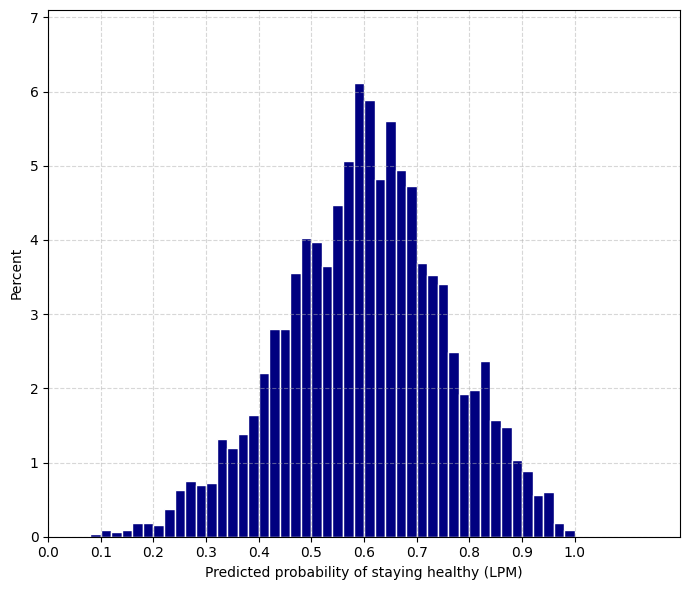

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7,6))
counts, bins, patches = ax.hist(
    share["pred_lpm"],
    bins=int((1-0)/0.02),
    range=(0, 1),
    color="navy",
    edgecolor="white"
)

# Convert counts to percent
percent = counts / counts.sum() * 100
ax.cla()  # Clear the current axes

ax.bar(bins[:-1], percent, width=(bins[1]-bins[0]), color="navy", edgecolor="white", align="edge")

ax.set_xlabel("Predicted probability of staying healthy (LPM)")
ax.set_ylabel("Percent")
ax.set_xlim(0, 1.2)
ax.set_ylim(0, 7.1)
ax.set_yticks([round(x, 2) for x in np.arange(0, 7.1, 1)])
ax.set_xticks([round(x, 2) for x in np.arange(0, 1.1, 0.1)])
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
share['pred_lpm'].describe().round(4)

count    3175.0000
mean        0.6028
std         0.1541
min         0.0905
25%         0.5002
50%         0.6079
75%         0.7054
max         0.9857
Name: pred_lpm, dtype: float64

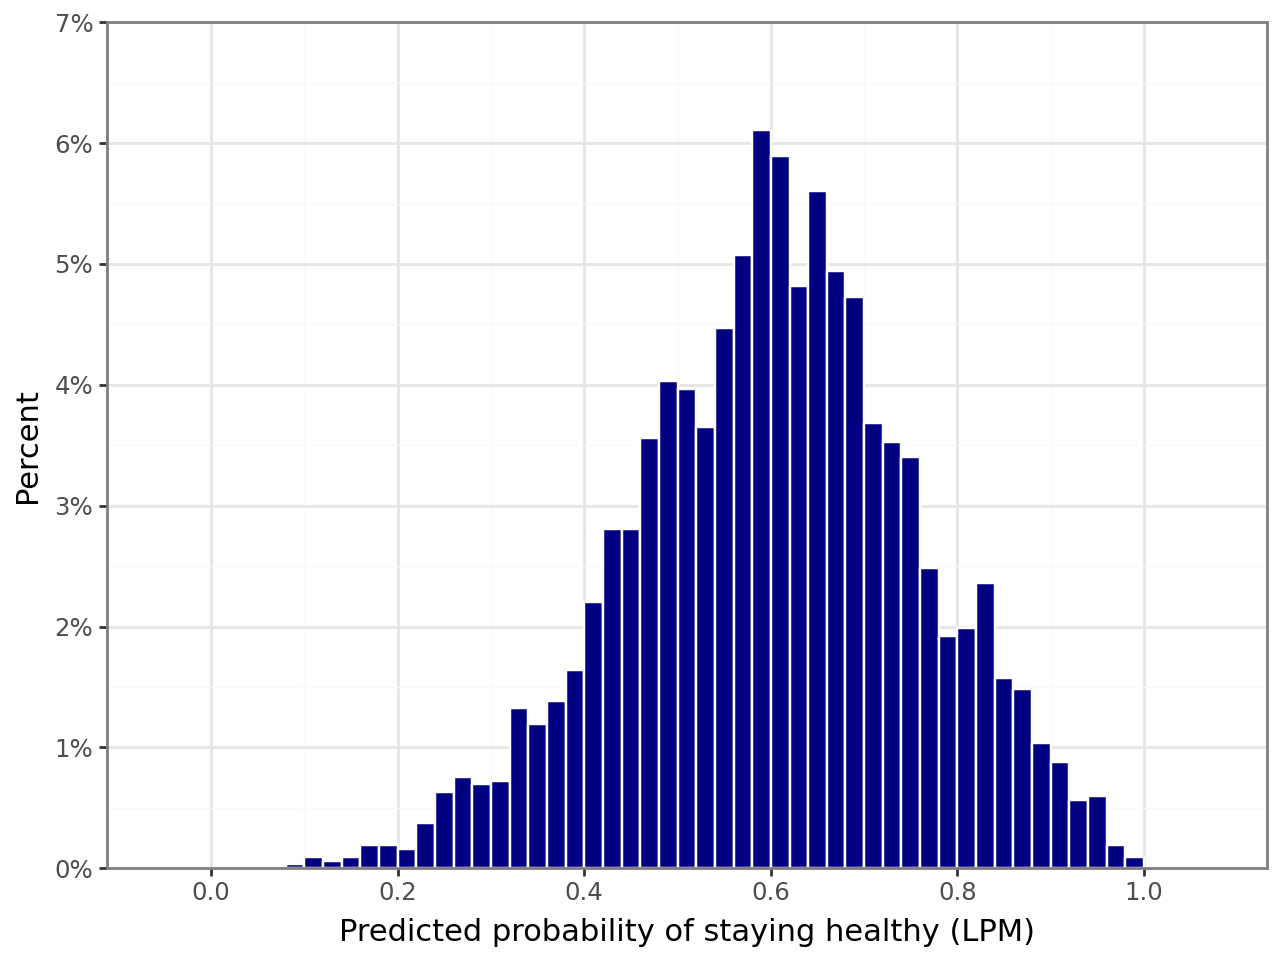

In [ ]:
g3 = (
    ggplot(share, aes(x="pred_lpm"))
    + geom_histogram(
        aes(y="stat(count)/sum(stat(count))"),
        binwidth=0.02,
        center=0.65,
        color="white",
        fill="navy",
        closed="right",
    )
    + labs(x="Predicted probability of staying healthy (LPM)", y="Percent")
    + scale_y_continuous(
        expand=[0.00, 0.0],
        limits=[0, 0.07],
        breaks=np.arange(0, 0.07, 0.01),
        labels=percent_format(),
    )
    + scale_x_continuous(expand=[0.1, 0.01], limits=[0, 1.02], breaks=np.arange(0, 1.02, 0.2))
    + theme_bw()
)
g3


In [ ]:
cuts = 100
share["q100_pred_lpm"] = pd.qcut(share["pred_lpm"], q=cuts, labels=range(1, cuts + 1))


In [ ]:
share.loc[
    share["q100_pred_lpm"] == 1,
    ["smoking", "ever_smoked", "female", "age", "eduyears", "income10", "bmi", "exerc"],
].describe().round(1)

# Bottom 1%


,female,age,eduyears,income10,bmi,exerc
count,32.0,32.0,32.0,32.0,32.0,32.0
mean,0.4,55.2,6.5,4.5,27.0,0.2
std,0.5,2.7,2.7,3.1,4.1,0.4
min,0.0,50.4,3.0,1.0,20.5,0.0
25%,0.0,53.2,4.0,1.8,23.7,0.0
50%,0.0,55.2,6.0,4.0,26.1,0.0
75%,1.0,57.4,8.2,7.0,30.1,0.0
max,1.0,59.4,12.0,10.0,36.3,1.0


In [ ]:
share.loc[
    share["q100_pred_lpm"] == 100,
    ["smoking", "ever_smoked", "female", "age", "eduyears", "income10", "bmi", "exerc"],
].describe().round(1)

# Top 1%


,female,age,eduyears,income10,bmi,exerc
count,32.0,32.0,32.0,32.0,32.0,32.0
mean,1.0,53.3,17.6,8.8,20.0,0.9
std,0.2,2.4,1.5,1.9,6.8,0.2
min,0.0,50.6,13.0,3.0,0.0,0.0
25%,1.0,51.5,16.8,8.8,20.0,1.0
50%,1.0,52.4,17.8,10.0,21.8,1.0
75%,1.0,54.3,18.0,10.0,23.3,1.0
max,1.0,60.0,21.0,10.0,26.4,1.0


# 4. PART - LOGIT VS. PROBIT MODELS

### Logit Model (GLM and Logit)

In [ ]:
# creating matrix for logit regression

y, X = dmatrices(
    "stayshealthy ~ smoking + ever_smoked + female + age + lspline_0 + lspline_1 + lspline_2 + income10 + lspline_4 + lspline_5 + exerc + country",
    share,
)

# GLM logit
logit = sm.GLM(y, X, family=sm.families.Binomial(link=sm.genmod.families.links.logit()))
logit = logit.fit()
logit.summary(),

(<class 'statsmodels.iolib.summary.Summary'>
 """
                  Generalized Linear Model Regression Results                  
 Dep. Variable:           stayshealthy   No. Observations:                 3175
 Model:                            GLM   Df Residuals:                     3150
 Model Family:                Binomial   Df Model:                           24
 Link Function:                  logit   Scale:                          1.0000
 Method:                          IRLS   Log-Likelihood:                -1968.0
 Date:                Tue, 15 Jul 2025   Deviance:                       3936.0
 Time:                        18:20:37   Pearson chi2:                 3.18e+03
 No. Iterations:                     4   Pseudo R-squ. (CS):            0.09878
 Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
 --------------------------------------------------

In [ ]:
share["pred_logit"] = logit_result.predict()
share["pred_logit"].describe()

count    3175.000000
mean        0.602835
std         0.154648
min         0.136611
25%         0.497812
50%         0.612834
75%         0.712762
max         0.911030
Name: pred_logit, dtype: float64

In [ ]:
share[["stayshealthy", "pred_logit"]]

,stayshealthy,pred_logit
0,1.0,0.611324
1,1.0,0.693080
2,1.0,0.711171
3,0.0,0.688926
4,0.0,0.591936
...,...,...
3170,1.0,0.516993
3171,1.0,0.633738
3172,1.0,0.523594
3173,1.0,0.454689


In [ ]:
# r2 score for logit model - comparing the predicted probabilities to the actual binary values (0 or 1), which is not ideal for classification task
from sklearn.metrics import r2_score
# brier score for logit model - good
from sklearn.metrics import brier_score_loss

r2_scor_logit = r2_score(share["stayshealthy"], share["pred_logit"])
brier_score_logit = brier_score_loss(share["stayshealthy"], share["pred_logit"])
print("Brier score (logit):", brier_score_logit)
print("R2 score (logit):", r2_scor_logit)

Brier score (logit): 0.215448581358726
R2 score (logit): 0.10014180107041026


In [ ]:
# just logit regression
logit = sm.Logit(y, X)
logit_result = logit.fit()
logit_result.summary(),

Optimization terminated successfully.
         Current function value: 0.619841
         Iterations 5


(<class 'statsmodels.iolib.summary.Summary'>
 """
                            Logit Regression Results                           
 Dep. Variable:           stayshealthy   No. Observations:                 3175
 Model:                          Logit   Df Residuals:                     3150
 Method:                           MLE   Df Model:                           24
 Date:                Tue, 15 Jul 2025   Pseudo R-squ.:                 0.07741
 Time:                        18:11:35   Log-Likelihood:                -1968.0
 converged:                       True   LL-Null:                       -2133.1
 Covariance Type:            nonrobust   LLR p-value:                 1.307e-55
                                     coef    std err          z      P>|z|      [0.025      0.975]
 -------------------------------------------------------------------------------------------------
 Intercept                         1.1756      0.844      1.393      0.164      -0.478       2.830
 smoking[T.5.

In [ ]:
# marginal effects for logit model 
logit_margef_results = logit_result.get_margeff()
logit_margef_results.summary()

### Probit Model

In [ ]:
probit = sm.Probit(y, X) # initiate 
probit_result = probit.fit() # teach
share["pred_probit"] = probit_result.predict() #predict 
probit_result.summary(), #check results

Optimization terminated successfully.
         Current function value: 0.619891
         Iterations 5


(<class 'statsmodels.iolib.summary.Summary'>
 """
                           Probit Regression Results                           
 Dep. Variable:           stayshealthy   No. Observations:                 3175
 Model:                         Probit   Df Residuals:                     3150
 Method:                           MLE   Df Model:                           24
 Date:                Tue, 15 Jul 2025   Pseudo R-squ.:                 0.07733
 Time:                        18:24:43   Log-Likelihood:                -1968.2
 converged:                       True   LL-Null:                       -2133.1
 Covariance Type:            nonrobust   LLR p-value:                 1.513e-55
                                     coef    std err          z      P>|z|      [0.025      0.975]
 -------------------------------------------------------------------------------------------------
 Intercept                         0.7543      0.514      1.467      0.142      -0.254       1.762
 smoking[T.5.

In [ ]:
# checking results of probit and logit
share[["stayshealthy", "pred_logit", "pred_probit"]]

,stayshealthy,pred_logit,pred_probit
0,1.0,0.611324,0.608228
1,1.0,0.693080,0.689789
2,1.0,0.711171,0.708390
3,0.0,0.688926,0.684878
4,0.0,0.591936,0.592518
...,...,...,...
3170,1.0,0.516993,0.517164
3171,1.0,0.633738,0.630269
3172,1.0,0.523594,0.523765
3173,1.0,0.454689,0.457986


In [ ]:
brier_score_probit = brier_score_loss(share["stayshealthy"], share["pred_probit"])
print("Brier score (probit):", brier_score_probit)

Brier score (probit): 0.21547633384224332


In [ ]:
share["pred_probit"].describe()

count    3175.000000
mean        0.602780
std         0.154227
min         0.133921
25%         0.498886
50%         0.611576
75%         0.710196
max         0.920291
Name: pred_probit, dtype: float64

### marginal effects for logit model
In simple words:
Marginal effects show how much the predicted probability changes if you increase one variable by 1, keeping others the same.
This helps us understand the real impact of each variable on the outcome, in terms of probability (not log-odds).

In [ ]:
# marginal effects for logit model 
probit_margef_results = probit_result.get_margeff()
probit_margef_results.summary(),

(<class 'statsmodels.iolib.summary.Summary'>
 """
        Probit Marginal Effects       
 Dep. Variable:           stayshealthy
 Method:                          dydx
 At:                           overall
                                    dy/dx    std err          z      P>|z|      [0.025      0.975]
 -------------------------------------------------------------------------------------------------
 smoking[T.5. No]                  0.0575      0.023      2.483      0.013       0.012       0.103
 ever_smoked[T.5. No]             -0.0159      0.020     -0.815      0.415      -0.054       0.022
 country[T.12. Germany]           -0.1886      0.071     -2.662      0.008      -0.328      -0.050
 country[T.13. Sweden]            -0.0263      0.059     -0.448      0.654      -0.141       0.089
 country[T.15. Spain]             -0.1388      0.040     -3.437      0.001      -0.218      -0.060
 country[T.16. Italy]             -0.2211      0.039     -5.641      0.000      -0.298      -0.144
 c

In [ ]:
df_plot = pd.melt(
    share[["pred_lpm", "pred_logit", "pred_probit"]].rename(
        columns={"pred_logit": "Logit", "pred_probit": "Probit"}
    ),
    value_vars=["Logit", "Probit"],
    id_vars=["pred_lpm"],
).sort_values(by=["variable"], ascending=False)

df_plot

,pred_lpm,variable,value
3175,0.610040,Probit,0.608228
4242,0.602116,Probit,0.606445
4240,0.454526,Probit,0.445086
4239,0.530392,Probit,0.527834
4238,0.616728,Probit,0.624557
...,...,...,...
2114,0.355135,Logit,0.347843
2113,0.519553,Logit,0.533412
2112,0.506120,Logit,0.519333
2111,0.399093,Logit,0.396074


### Figure 11.5 Predicted probabilities from three different models

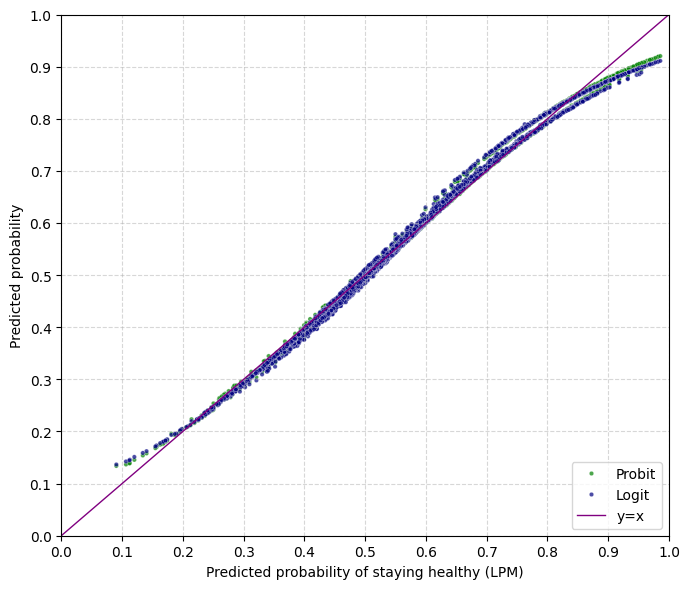

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=df_plot,
    x="pred_lpm",
    y="value",
    hue="variable",
    palette={"Logit": "navy", "Probit": "green"},
    s=10,
    alpha=0.7
)
plt.plot([0, 1], [0, 1], color="purple", linewidth=1, label="y=x")
plt.xlabel("Predicted probability of staying healthy (LPM)")
plt.ylabel("Predicted probability")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks([round(x, 2) for x in np.arange(0, 1.1, 0.1)])
plt.yticks([round(x, 2) for x in np.arange(0, 1.1, 0.1)])
plt.legend(title="", loc="lower right")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Part 5 goodness of fit

In [ ]:
lpmbase = smf.ols("stayshealthy ~ smoking_num", data=share).fit()
share["pred_lpmbase"] = lpmbase.predict()

### Figure 11.7 Staying healthy and the distribution of the predicted probability of staying healthy. Two linear probability model

(a) Simple LPM

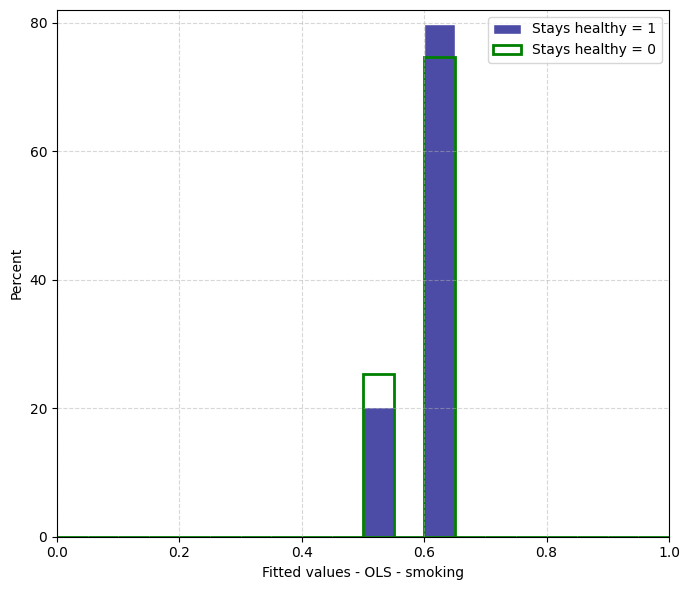

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6))

# Histogram for stayshealthy == 1
sns.histplot(
    share.loc[share["stayshealthy"] == 1, "pred_lpmbase"],
    bins=np.arange(0, 1.05, 0.05),
    color="navy",
    alpha=0.7,
    label="Stays healthy = 1",
    stat="percent",
    edgecolor="white"
)

# Histogram for stayshealthy == 0
sns.histplot(
    share.loc[share["stayshealthy"] == 0, "pred_lpmbase"],
    bins=np.arange(0, 1.05, 0.05),
    color="none",
    edgecolor="green",
    linewidth=2,
    label="Stays healthy = 0",
    stat="percent"
)

plt.xlabel("Fitted values - OLS - smoking")
plt.ylabel("Percent")
plt.xlim(0, 1)
plt.ylim(0, 82)
plt.xticks(np.arange(0, 1.1, 0.2))
plt.yticks(np.arange(0, 82, 20))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

(b) Rich LPM

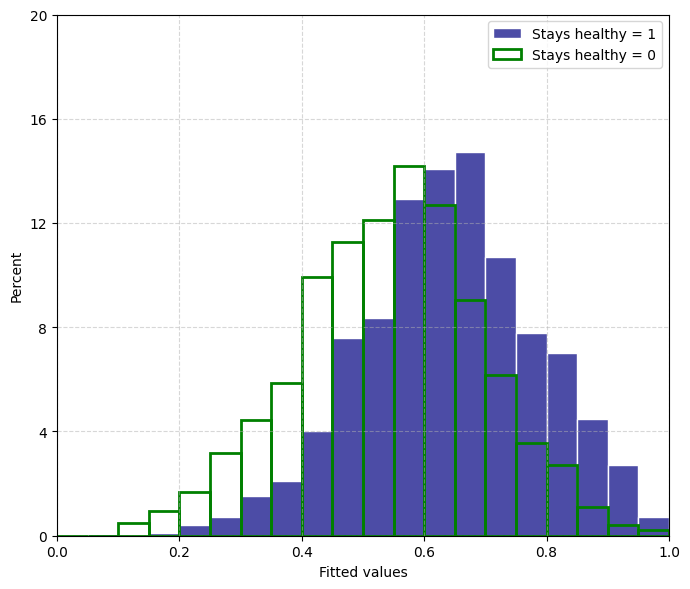

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6))

# Histogram for stayshealthy == 1
sns.histplot(
    share.loc[share["stayshealthy"] == 1, "pred_lpm"],
    bins=np.arange(0, 1.05, 0.05),
    color="navy",
    alpha=0.7,
    label="Stays healthy = 1",
    stat="percent",
    edgecolor="white"
)

# Histogram for stayshealthy == 0
sns.histplot(
    share.loc[share["stayshealthy"] == 0, "pred_lpm"],
    bins=np.arange(0, 1.05, 0.05),
    color="none",
    edgecolor="green",
    linewidth=2,
    label="Stays healthy = 0",
    stat="percent"
)

plt.xlabel("Fitted values")
plt.ylabel("Percent")
plt.xlim(0, 1)
plt.ylim(0, 20)
plt.xticks(np.arange(0, 1.1, 0.2))
plt.yticks(np.arange(0, 21, 4))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


#### Table 11.4 Comparing probability models – mean and median

In [ ]:
share.groupby("stayshealthy")[
    ["pred_lpmbase", "pred_lpm", "pred_logit", "pred_probit"]
].mean().round(3)


,pred_lpmbase,pred_lpm,pred_logit,pred_probit
stayshealthy,,,,
0.0,0.601,0.543,0.543,0.543
1.0,0.604,0.642,0.643,0.642


In [ ]:
share.groupby("stayshealthy")[
    ["pred_lpmbase", "pred_lpm", "pred_logit", "pred_probit"
]].median().round(3)

,pred_lpmbase,pred_lpm,pred_logit,pred_probit
stayshealthy,,,,
0.0,0.619,0.550,0.550,0.55
1.0,0.619,0.645,0.653,0.65


### Table 11.5 Statistics of goodness of fit for the probability predictions of three models

In [ ]:
pd.DataFrame(
    {
        "R-squared": [
            lpm3.rsquared,
            r2_score(share["stayshealthy"], share["pred_logit"]),
            r2_score(share["stayshealthy"], share["pred_probit"]),
        ],
        "Brier-score": [
            mean_squared_error(share["stayshealthy"], share["pred_lpm"]),
            mean_squared_error(share["stayshealthy"], share["pred_logit"]),
            mean_squared_error(share["stayshealthy"], share["pred_probit"]),
        ],
        "Pseudo R-squared": [np.nan, logit_result.prsquared, probit_result.prsquared],
        "Log-loss": [
            -1 * log_loss(share["stayshealthy"], share["pred_lpm"]),
            -1 * log_loss(share["stayshealthy"], share["pred_logit"]),
            -1 * log_loss(share["stayshealthy"], share["pred_probit"]),
        ],
    },
    index=["LPM", "Logit", "Probit"],
).T.round(3)


,LPM,Logit,Probit
R-squared,0.099,0.100,0.100
Brier-score,0.216,0.215,0.215
Pseudo R-squared,NaN,0.077,0.077
Log-loss,-0.621,-0.620,-0.620


### Figure 11.8 Calibration curves for the predictions of the linear probability and logit models

(a) LPM

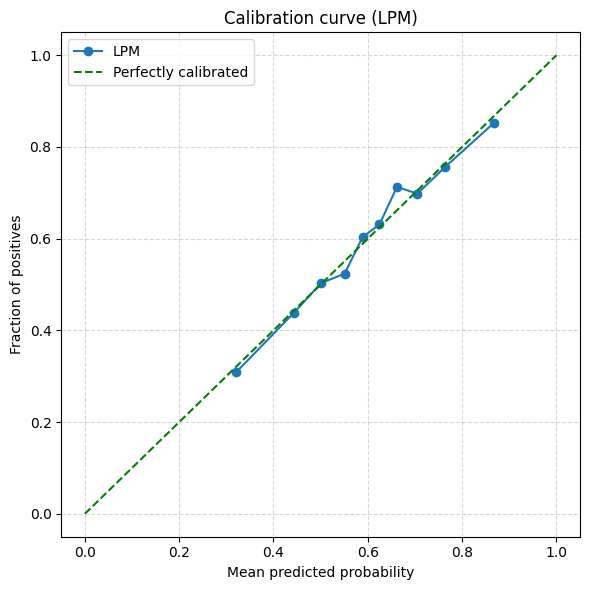

In [ ]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Calculate calibration curve
prob_true, prob_pred = calibration_curve(share["stayshealthy"], share["pred_lpm"], n_bins=10, strategy='quantile')

plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='LPM')
plt.plot([0, 1], [0, 1], linestyle='--', color='green', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve (LPM)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


(b) Logit

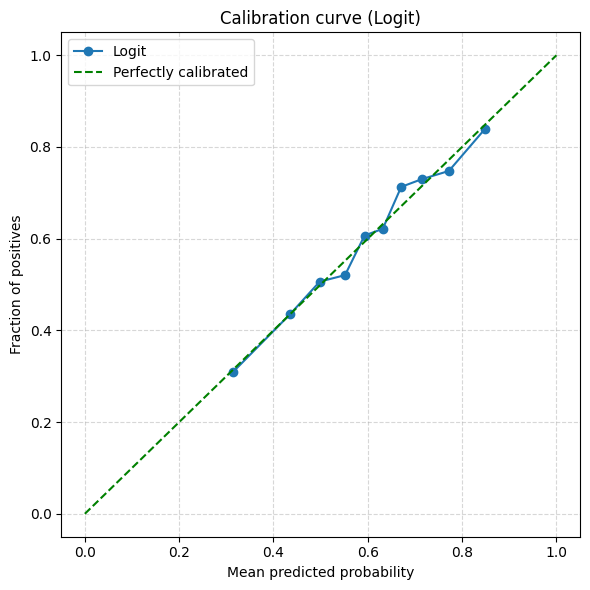

In [ ]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Calculate calibration curve
prob_true, prob_pred = calibration_curve(share["stayshealthy"], share["pred_logit"], n_bins=10, strategy='quantile')

plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Logit')
plt.plot([0, 1], [0, 1], linestyle='--', color='green', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve (Logit)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
## Part 7

In [ ]:
df = share[["pred_lpmbase", "pred_lpm", "pred_logit", "pred_probit"]].copy()


In [ ]:
for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        if df.iloc[i, j] > 0.5:
            df.iloc[i, j] = 1
        else:
            df.iloc[i, j] = 0


In [ ]:
pd.crosstab(df.iloc[:, 0], share["stayshealthy"], normalize="all")


stayshealthy,0.0,1.0
pred_lpmbase,,
1.0,0.395304,0.604696


In [ ]:
for j in range(df.shape[1]):
    print(pd.crosstab(df.iloc[:, j], share["stayshealthy"], normalize="all"))
    print(pd.crosstab(df.iloc[:, j], share["stayshealthy"], normalize="columns"))


stayshealthy       0.0       1.0
pred_lpmbase                    
1.0           0.395304  0.604696
stayshealthy  0.0  1.0
pred_lpmbase          
1.0           1.0  1.0
stayshealthy       0.0       1.0
pred_lpm                        
0.0           0.149244  0.100675
1.0           0.246060  0.504021
stayshealthy       0.0       1.0
pred_lpm                        
0.0           0.377543  0.166489
1.0           0.622457  0.833511
stayshealthy       0.0       1.0
pred_logit                      
0.0           0.153104  0.101962
1.0           0.242200  0.502734
stayshealthy       0.0       1.0
pred_logit                      
0.0           0.387307  0.168617
1.0           0.612693  0.831383
stayshealthy       0.0       1.0
pred_probit                     
0.0           0.150209  0.101640
1.0           0.245095  0.503056
stayshealthy       0.0       1.0
pred_probit                     
0.0           0.379984  0.168085
1.0           0.620016  0.831915


## Figure 11.4 The logit and probit link functions

In [ ]:
share = pd.read_csv(os.path.join(data_out, "ch11_share.csv"))


In [ ]:
share["country"] = share["country"].astype("category")


In [ ]:
y, X = dmatrices(
    "stayshealthy ~ smoking + ever_smoked + female + age + lspline(eduyears,[8,18]) + \
                 income10 + lspline(bmi,[35]) + exerc + country",
    share,
)


In [ ]:
logit = sm.Logit(y, X).fit()


Optimization terminated successfully.
         Current function value: 0.617166
         Iterations 5


In [ ]:
logit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           stayshealthy   No. Observations:                 3109
Model:                          Logit   Df Residuals:                     3084
Method:                           MLE   Df Model:                           24
Date:                Thu, 06 Oct 2022   Pseudo R-squ.:                 0.08031
Time:                        15:48:16   Log-Likelihood:                -1918.8
converged:                       True   LL-Null:                       -2086.3
Covariance Type:            nonrobust   LLR p-value:                 1.329e-56
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         2.2781      0.885      2.573      0.010       0.543       4.013
country[T.12]                    -0.9828      0.330     -2.978      0.003      -1.630      -0.336
country[T.13]                    -0.1972      0.276     -0.714      0.475      -0.739       0.344
country[T.15]                    -0.6560      0.194     -3.382      0.001      -1.036      -0.276
country[T.16]                    -1.1196      0.185     -6.051      0.000      -1.482      -0.757
country[T.17]                    -0.7850      0.169     -4.640      0.000      -1.116      -0.453
country[T.18]                     0.4358      0.181      2.411      0.016       0.082       0.790
country[T.20]                     0.0679      0.159      0.426      0.670      -0.244       0.380
country[T.23]                    -0.5734      0.157     -3.650      0.000      -0.881      -0.265
country[T.28]                    -0.7552      0.176     -4.297      0.000      -1.100      -0.411
country[T.29]                    -1.4707      0.395     -3.719      0.000      -2.246      -0.696
country[T.33]                    -1.5783      0.301     -5.243      0.000      -2.168      -0.988
country[T.34]                    -0.9203      0.205     -4.482      0.000      -1.323      -0.518
country[T.35]                    -1.3535      0.211     -6.416      0.000      -1.767      -0.940
smoking                          -0.2840      0.109     -2.601      0.009      -0.498      -0.070
ever_smoked                       0.0782      0.092      0.849      0.396      -0.102       0.259
female                            0.1608      0.082      1.964      0.050       0.000       0.321
age                              -0.0123      0.014     -0.859      0.391      -0.040       0.016
lspline(eduyears, [8, 18])[0]    -0.0030      0.033     -0.090      0.928      -0.068       0.062
lspline(eduyears, [8, 18])[1]     0.0791      0.016      5.022      0.000       0.048       0.110
lspline(eduyears, [8, 18])[2]    -0.0457      0.055     -0.825      0.410      -0.154       0.063
income10                          0.0356      0.015      2.452      0.014       0.007       0.064
lspline(bmi, [35])[0]            -0.0575      0.011     -5.033      0.000      -0.080      -0.035
lspline(bmi, [35])[1]             0.0311      0.071      0.439      0.661      -0.108       0.170
exerc                             0.2548      0.079      3.229      0.001       0.100       0.410
=================================================================================================
"""

In [ ]:
share["bx_logit"] = np.asarray(X).dot(logit.params)


In [ ]:
share["Logit"] = logistic.cdf(share["bx_logit"])


In [ ]:
probit = sm.Probit(y, X).fit()


Optimization terminated successfully.
         Current function value: 0.617255
         Iterations 5


In [ ]:
probit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:           stayshealthy   No. Observations:                 3109
Model:                         Probit   Df Residuals:                     3084
Method:                           MLE   Df Model:                           24
Date:                Thu, 06 Oct 2022   Pseudo R-squ.:                 0.08018
Time:                        15:48:16   Log-Likelihood:                -1919.0
converged:                       True   LL-Null:                       -2086.3
Covariance Type:            nonrobust   LLR p-value:                 1.722e-56
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         1.4340      0.540      2.656      0.008       0.376       2.492
country[T.12]                    -0.5952      0.203     -2.926      0.003      -0.994      -0.197
country[T.13]                    -0.1128      0.166     -0.678      0.498      -0.439       0.213
country[T.15]                    -0.4007      0.119     -3.368      0.001      -0.634      -0.167
country[T.16]                    -0.6872      0.113     -6.082      0.000      -0.909      -0.466
country[T.17]                    -0.4761      0.103     -4.615      0.000      -0.678      -0.274
country[T.18]                     0.2573      0.105      2.440      0.015       0.051       0.464
country[T.20]                     0.0425      0.096      0.445      0.657      -0.145       0.230
country[T.23]                    -0.3450      0.095     -3.622      0.000      -0.532      -0.158
country[T.28]                    -0.4579      0.108     -4.252      0.000      -0.669      -0.247
country[T.29]                    -0.8784      0.235     -3.740      0.000      -1.339      -0.418
country[T.33]                    -0.9741      0.182     -5.359      0.000      -1.330      -0.618
country[T.34]                    -0.5592      0.126     -4.426      0.000      -0.807      -0.312
country[T.35]                    -0.8280      0.129     -6.407      0.000      -1.081      -0.575
smoking                          -0.1705      0.066     -2.568      0.010      -0.301      -0.040
ever_smoked                       0.0443      0.056      0.793      0.428      -0.065       0.154
female                            0.0973      0.050      1.953      0.051      -0.000       0.195
age                              -0.0083      0.009     -0.955      0.339      -0.025       0.009
lspline(eduyears, [8, 18])[0]    -0.0021      0.020     -0.102      0.918      -0.041       0.037
lspline(eduyears, [8, 18])[1]     0.0478      0.010      5.015      0.000       0.029       0.066
lspline(eduyears, [8, 18])[2]    -0.0286      0.033     -0.864      0.388      -0.093       0.036
income10                          0.0216      0.009      2.446      0.014       0.004       0.039
lspline(bmi, [35])[0]            -0.0346      0.007     -5.002      0.000      -0.048      -0.021
lspline(bmi, [35])[1]             0.0169      0.044      0.388      0.698      -0.069       0.102
exerc                             0.1510      0.048      3.148      0.002       0.057       0.245
=================================================================================================
"""

In [ ]:
share["bx_probit"] = np.asarray(X).dot(probit.params)


In [ ]:
share["Probit"] = norm.cdf(share["bx_probit"])


In [ ]:
share_plot = pd.melt(
    share[["bx_logit", "Logit", "Probit"]],
    id_vars=["bx_logit"],
    value_vars=["Logit", "Probit"],
)


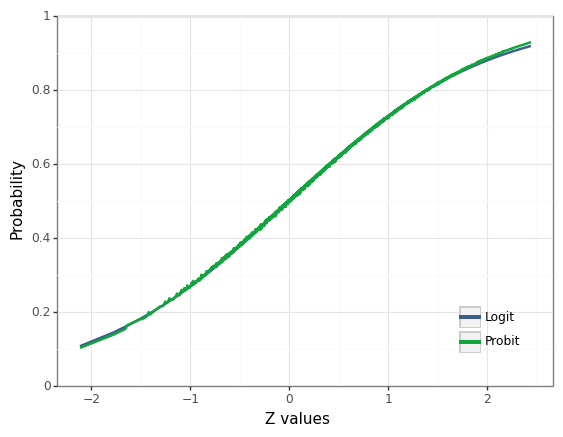

<ggplot: (687368593)>

In [ ]:
g4 = (
    ggplot(data=share_plot)
    + geom_line(aes(x="bx_logit", y="value", color="variable"), size=1)
    + ylab("Probability")
    + xlab("Z values")
    + scale_color_manual(values=color[0:2], name=" ", labels=("Logit", "Probit"))
    + scale_y_continuous(expand=[0.00, 0.00], limits=[0, 1], breaks=seq(0, 1.1, 0.2))
    + theme_bw()
    + theme(
        legend_position=(0.8, 0.25),
        legend_direction="vertical",
        legend_background=element_blank(),
    )
)
g4